**random pic segmentation without annotation**

In [ ]:
# ============================================================
# SegFormer Multi-Precision + P3109 Quantization + Analysis
# ============================================================

import os
import time
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# -----------------------------
# Core: P3109 simulation
# -----------------------------
def float_to_p3109(x: torch.Tensor,
                   K: int = 8,
                   P: int = 3,
                   rounding: str = "nearest_even",
                   preserve_dtype: bool = True,
                   eps: float = 1e-45) -> torch.Tensor:
    """
    Simulate P3109-like quantization while keeping tensor shape.
    """
    orig_shape = x.shape
    orig_dtype = x.dtype
    x_flat = x.flatten().to(torch.float32)

    e_bits = K - P
    f_bits = P - 1
    bias = (2 ** (e_bits - 1)) - 1
    max_stored_exp = (2 ** e_bits) - 2
    E_max_unbiased = max_stored_exp - bias
    E_min_unbiased = 1 - bias

    out_flat = torch.zeros_like(x_flat)
    is_zero = x_flat == 0
    is_nan = torch.isnan(x_flat)
    is_inf = torch.isinf(x_flat)
    signbit = torch.signbit(x_flat)
    absx = x_flat.abs()

    # NaN / Inf
    out_flat[is_nan] = float('nan')
    out_flat[is_inf] = float('inf') * torch.sign(x_flat[is_inf])

    finite_mask = torch.isfinite(x_flat) & (~is_zero) & (~is_nan) & (~is_inf)
    if finite_mask.any():
        xf = absx[finite_mask]
        m, e = torch.frexp(xf)
        mant = m * 2.0
        exp_unbiased = e - 1

        normal_mask = (exp_unbiased >= E_min_unbiased) & (exp_unbiased <= E_max_unbiased)
        subnormal_mask = exp_unbiased < E_min_unbiased
        overflow_mask = exp_unbiased > E_max_unbiased

        # Normals
        if normal_mask.any():
            mant_n = mant[normal_mask]
            exp_n = exp_unbiased[normal_mask].to(torch.long)
            f = mant_n - 1.0
            scaled = f * (2.0 ** f_bits)
            scaled_q = torch.round(scaled) if rounding=="nearest_even" else torch.trunc(scaled)
            carry_mask = scaled_q >= 2**f_bits
            if carry_mask.any():
                scaled_q = scaled_q.clone()
                exp_n = exp_n.clone()
                scaled_q[carry_mask] = 0.0
                exp_n[carry_mask] += 1
            overflow_after = exp_n > E_max_unbiased
            mant_q = 1.0 + scaled_q / (2.0 ** f_bits)
            val_n = mant_q * (2.0 ** exp_n)
            val_n[overflow_after] = float('inf')
            out_flat[torch.nonzero(finite_mask, as_tuple=False).squeeze(1)[normal_mask]] = val_n

        # Subnormals
        if subnormal_mask.any():
            scaled_frac = xf[subnormal_mask] / (2**E_min_unbiased) * (2**f_bits)
            frac_q = torch.round(scaled_frac) if rounding=="nearest_even" else torch.trunc(scaled_frac)
            frac_q = torch.clamp(frac_q, 0, 2**f_bits - 1)
            val_s = (frac_q / (2**f_bits)) * (2**E_min_unbiased)
            out_flat[torch.nonzero(finite_mask, as_tuple=False).squeeze(1)[subnormal_mask]] = val_s

        # Overflow
        if overflow_mask.any():
            out_flat[torch.nonzero(finite_mask, as_tuple=False).squeeze(1)[overflow_mask]] = float('inf')

    # Restore sign
    out_flat = out_flat * (~signbit).to(out_flat.dtype) + (-out_flat) * signbit.to(out_flat.dtype)
    # Restore zero sign
    out_flat[is_zero] = x_flat[is_zero]*0.0

    out = out_flat.view(orig_shape)
    return out.to(orig_dtype) if preserve_dtype else out

def quantize_model_p3109(model):
    """Quantize model weights safely"""
    for name, param in model.named_parameters():
        if param.requires_grad:
            with torch.no_grad():
                param.data.copy_(float_to_p3109(param.data))
    return model

# -----------------------------
# Visualization utils
# -----------------------------
def visualize_mask(pred_mask, title, save_path):
    plt.figure(figsize=(5,5))
    plt.imshow(pred_mask)
    plt.title(title)
    plt.axis("off")
    plt.savefig(save_path)
    plt.close()

# -----------------------------
# Error metrics
# -----------------------------
def compute_error(a,b):
    a,b = a.float(), b.float()
    return {"MAE": torch.mean(torch.abs(a-b)).item(),
            "L2": torch.norm(a-b).item(),
            "MaxAbs": torch.max(torch.abs(a-b)).item()}

def dice_coeff(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    return (2.0 * intersection) / (pred_flat.numel() + target_flat.numel() + eps)

def iou_score(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    union = pred_flat.numel() + target_flat.numel() - intersection
    return intersection / (union + eps)

# -----------------------------
# Main experiment
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "nvidia/segformer-b2-finetuned-ade-512-512"

os.makedirs("pred_visualizations", exist_ok=True)
os.makedirs("features_cache", exist_ok=True)
os.makedirs("metrics_cache", exist_ok=True)

precisions = ["P3109","FP32","FP64","TF32","BFloat16"]
baseline_precision = "FP32"

# Load model
model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
processor = SegformerFeatureExtractor.from_pretrained(model_name)
model.eval()

# Example image
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
inputs = processor(images=image, return_tensors="pt").to(device)

# Prepare GT mask
with torch.no_grad():
    dummy_out = model(**inputs)
output_shape = dummy_out.logits.shape[2:]
gt_mask_resized = np.array(image.resize(output_shape[::-1]))[:,:,0]
gt_mask_tensor = torch.from_numpy(gt_mask_resized).long()

# Safe Hook for capturing activations
def quant_hook(module, input, output, name):
    if torch.is_tensor(output):
        layer_outputs[name] = float_to_p3109(output)
    elif isinstance(output, (list, tuple)):
        layer_outputs[name] = tuple(float_to_p3109(o) if torch.is_tensor(o) else o for o in output)
    else:
        layer_outputs[name] = output

# Run all precisions
all_features = {}
all_metrics = {}
timings = {}

for p in precisions:
    print(f"\n========== RUN {p} ==========")
    layer_outputs = {}
    start = time.time()

    if p=="P3109":
        p_model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
        p_model.eval()
        quantize_model_p3109(p_model)
        for name,module in p_model.named_modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                module.register_forward_hook(lambda m,i,o,n=name: quant_hook(m,i,o,n))
        p_inputs = {k: float_to_p3109(v) if torch.is_tensor(v) else v for k,v in inputs.items()}
        with torch.no_grad():
            outputs = p_model(**p_inputs)

    elif p=="FP32":
        model_fp = model.float()
        for name,module in model_fp.named_modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                module.register_forward_hook(lambda m,i,o,n=name: quant_hook(m,i,o,n))
        in_fp = {k:v.float() for k,v in inputs.items()}
        with torch.no_grad():
            outputs = model_fp(**in_fp)

    elif p=="FP64":
        model_fp = model.double()
        for name,module in model_fp.named_modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                module.register_forward_hook(lambda m,i,o,n=name: quant_hook(m,i,o,n))
        in_fp = {k:v.double() for k,v in inputs.items()}
        with torch.no_grad():
            outputs = model_fp(**in_fp)

    elif p=="TF32":
        torch.backends.cuda.matmul.allow_tf32=True
        model_fp = model.float()
        for name,module in model_fp.named_modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                module.register_forward_hook(lambda m,i,o,n=name: quant_hook(m,i,o,n))
        in_fp = {k:v.float() for k,v in inputs.items()}
        with torch.no_grad():
            outputs = model_fp(**in_fp)

    elif p=="BFloat16":
        model_fp = model.to(torch.bfloat16)
        for name,module in model_fp.named_modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                module.register_forward_hook(lambda m,i,o,n=name: quant_hook(m,i,o,n))
        in_fp = {k:v.to(torch.bfloat16) for k,v in inputs.items()}
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            with torch.no_grad():
                outputs = model_fp(**in_fp)

    # Prediction mask
    pred_mask = outputs.logits.argmax(dim=1)[0].cpu()
    visualize_mask(pred_mask, f"Pred Mask {p}", f"pred_visualizations/pred_{p}.png")

    # Pixel Accuracy
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask_tensor.flatten()
    min_len = min(len(pred_flat), len(gt_flat))
    acc = (pred_flat[:min_len] == gt_flat[:min_len]).float().mean().item()

    # Dice and IoU
    dice = dice_coeff(pred_mask, gt_mask_tensor)
    iou = iou_score(pred_mask, gt_mask_tensor)

    all_metrics[p] = {"pixel_acc": acc, "dice": dice, "iou": iou}
    timings[p] = time.time() - start
    print(f"Time {timings[p]:.3f}s")
    print(f"Layers captured: {len(layer_outputs)}")
    all_features[p] = layer_outputs

    # Save
    torch.save(layer_outputs, f'features_cache/{p}.pt')
    torch.save(all_metrics[p], f'metrics_cache/{p}.pt')

# Activation error analysis (vs FP32 baseline)
records = []
for p in precisions:
    if p==baseline_precision: continue
    for k,v in all_features[p].items():
        if k not in all_features[baseline_precision]: continue
        a = all_features[baseline_precision][k]
        b = v
        if isinstance(a,list) or isinstance(a,tuple):
            for i in range(len(a)):
                e = compute_error(a[i],b[i])
                records.append({"precision":p,"layer":k,"idx":i,**e})
        else:
            e = compute_error(a,b)
            records.append({"precision":p,"layer":k,"idx":0,**e})

df = pd.DataFrame(records)
df.to_csv("feature_diff_summary.csv", index=False)

# Save overall metrics
metrics_df = pd.DataFrame.from_dict(all_metrics, orient="index")
metrics_df.to_csv("mask_metrics_summary.csv")
print("✅ Done! All precisions run, activations saved, metrics CSV generated.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:35: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]


========== RUN P3109 ==========
Time 31.963s
Layers captured: 188

========== RUN FP32 ==========
Time 27.371s
Layers captured: 188

========== RUN FP64 ==========
Time 60.718s
Layers captured: 188

========== RUN TF32 ==========
Time 72.877s
Layers captured: 188

========== RUN BFloat16 ==========
Time 688.279s
Layers captured: 188
✅ Done! All precisions run, activations saved, metrics CSV generated.


In [ ]:
# -----------------------------
# Core: P3109 simulation
# -----------------------------
def float_to_p3109(x: torch.Tensor,
                   K: int = 8,
                   P: int = 3,
                   rounding: str = "nearest_even",
                   preserve_dtype: bool = True,
                   eps: float = 1e-45) -> torch.Tensor:
    """
    Simulate IEEE P3109-like compact floating point quantization on tensor x.
    - K: total bits (sign + exponent + significand).
    - P: precision (number of significand bits INCLUDING the implicit leading 1 for normals).
         So fraction bits = P - 1.
    - rounding: "nearest_even", "toward_zero", "floor", "ceil"
    - preserve_dtype: if True, returns tensor in same dtype as input (float32/float64)
                      (values are quantized but stored as float32/64).
    Returns quantized tensor (floating values reconstructed from K/P representation).
    Notes:
      - This handles Inf/NaN, normals, subnormals, zero, sign, exponent bias, rounding.
      - Assumes IEEE-like layout: sign(1) | exponent(e_bits) | fraction(f_bits),
        where e_bits = K - 1 - f_bits, f_bits = P - 1  -> e_bits = K - P.
    """
    if P < 1:
        raise ValueError("P must be >= 1")
    e_bits = K - P
    if e_bits < 1:
        raise ValueError("K and P invalid: need at least 1 exponent bit")

    f_bits = P - 1
    # Exponent bias (standard IEEE pattern)
    bias = (2 ** (e_bits - 1)) - 1
    # stored exponent values:
    max_stored_exp = (2 ** e_bits) - 2  # all ones reserved for Inf/NaN
    min_stored_exp = 1
    # Unbiased exponent for max/min_normal
    E_max_unbiased = max_stored_exp - bias
    E_min_unbiased = 1 - bias  # smallest normal exponent

    # For constructing subnormal quantization, subnormal exponent uses stored=0, value = fraction * 2^{E_min_unbiased}
    # fraction has f_bits bits (no implicit leading 1)
    # fraction integer ranges [0, 2^{f_bits} -1]

    # Work in float32 for intermediate stability (but keep original dtype if requested)
    orig_dtype = x.dtype
    work_dtype = torch.float32 if x.dtype != torch.float64 else torch.float64
    x = x.to(work_dtype)

    # Handle NaN/Inf separately
    is_nan = torch.isnan(x)
    is_inf = torch.isinf(x)
    sign = torch.sign(x)  # sign will be 0 for zeros; we need signbit
    signbit = torch.signbit(x)  # bool

    # absolute value
    absx = x.abs()

    # Zero handling (positive/negative zeros)
    is_zero = (absx == 0)

    # Prepare output
    out = torch.zeros_like(x, dtype=work_dtype)

    # Put Inf/NaN back
    out[is_nan] = torch.nan
    out[is_inf] = torch.sign(x[is_inf]) * float("inf")

    # Mask of finite & nonzero
    finite_mask = torch.isfinite(x) & (~is_zero) & (~is_nan) & (~is_inf)

    if finite_mask.any():
        xf = absx[finite_mask]

        # Use frexp to get mantissa m in [0.5, 1.0) and exponent e (integer)
        # x = m * 2**e
        m, e = torch.frexp(xf)  # m in [0.5,1)
        # Convert to normalized mantissa in [1.0, 2.0): mant = m * 2, exp_unbiased = e - 1
        mant = m * 2.0
        exp_unbiased = e - 1  # integer exponent (unbiased)

        # CASE 1: Normalized numbers: exp_unbiased in [E_min_unbiased, E_max_unbiased]
        normal_mask = (exp_unbiased >= E_min_unbiased) & (exp_unbiased <= E_max_unbiased)
        # CASE 2: Subnormals: exp_unbiased < E_min_unbiased (very small) -> handled as subnormal
        subnormal_mask = exp_unbiased < E_min_unbiased
        # CASE 3: Overflowed beyond max normal -> treat as Inf (will be handled if rounding pushes above E_max)
        overflow_mask = exp_unbiased > E_max_unbiased

        # Process normals
        if normal_mask.any():
            mant_n = mant[normal_mask]  # in [1,2)
            exp_n = exp_unbiased[normal_mask].to(torch.long)  # integer

            # fraction f in [0,1): f = mant - 1
            f = mant_n - 1.0
            # scale fraction to integer steps of 2^{-f_bits}: scaled = f * 2^{f_bits}
            scaled = f * (2.0 ** f_bits)

            # rounding according to requested mode
            if rounding == "nearest_even":
                scaled_q = torch.round(scaled)  # ties to even
            elif rounding == "toward_zero":
                scaled_q = torch.trunc(scaled)
            elif rounding == "floor":
                scaled_q = torch.floor(scaled)
            elif rounding == "ceil":
                scaled_q = torch.ceil(scaled)
            else:
                raise ValueError("Unsupported rounding")

            # Handle possible carry when scaled_q == 2^{f_bits} (i.e., mantissa rounded from 1.111... to 2.0)
            carry_mask = (scaled_q >= (2 ** f_bits))
            if carry_mask.any():
                # increment exponent for those entries, set fraction to 0
                idxs = torch.nonzero(normal_mask, as_tuple=False).squeeze(1)
                carry_idxs = idxs[carry_mask]
                # For vectorization, we update scaled_q and exp_n
                scaled_q = scaled_q.clone()
                scaled_q[carry_mask] = 0.0
                exp_n = exp_n.clone()
                exp_n[carry_mask] = exp_n[carry_mask] + 1

            # Now check for exponent overflow after carry
            # When exp_n > E_max_unbiased -> becomes Inf
            overflow_after_carry = exp_n > E_max_unbiased
            # Reconstruct mantissa: mant_q = 1 + scaled_q / 2^{f_bits}
            mant_q = 1.0 + scaled_q / (2.0 ** f_bits)
            # Reconstruct value
            val_n = mant_q * (2.0 ** exp_n)
            # Where overflow_after_carry -> set to Inf
            val_n[overflow_after_carry] = float("inf")

            # Write back to out in positions corresponding to normal_mask
            # find indices in xf that correspond to normal_mask
            normal_indices = torch.nonzero(normal_mask, as_tuple=False).squeeze(1)
            # Map back positions in original tensor
            orig_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)[normal_indices]
            out[orig_positions] = val_n

        # Process subnormals
        if subnormal_mask.any():
            mant_s = mant[subnormal_mask]  # still mant computed from frexp; but for subnormals we need different formula
            exp_s = exp_unbiased[subnormal_mask].to(torch.long)
            # For subnormals: stored exponent = 0; effective exponent = E_min_unbiased
            # The representation is: value = fraction / 2^{f_bits} * 2^{E_min_unbiased}
            # Compute scaled_fraction = xf / 2^{E_min_unbiased} * 2^{f_bits}
            # scaled_fraction = xf / (2^{E_min_unbiased - f_bits})
            scaled_fraction = xf[subnormal_mask] / (2.0 ** E_min_unbiased) * (2.0 ** f_bits)
            # Now round scaled_fraction to integer in [0, 2^{f_bits}-1]
            if rounding == "nearest_even":
                frac_q = torch.round(scaled_fraction)
            elif rounding == "toward_zero":
                frac_q = torch.trunc(scaled_fraction)
            elif rounding == "floor":
                frac_q = torch.floor(scaled_fraction)
            elif rounding == "ceil":
                frac_q = torch.ceil(scaled_fraction)
            else:
                raise ValueError("Unsupported rounding")

            # clamp to valid range for fraction
            frac_q = torch.clamp(frac_q, 0.0, float(2 ** f_bits - 1))

            # If frac_q becomes zero -> true zero
            val_s = (frac_q / (2.0 ** f_bits)) * (2.0 ** E_min_unbiased)
            # Map back positions
            sub_indices = torch.nonzero(subnormal_mask, as_tuple=False).squeeze(1)
            orig_positions_s = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)[sub_indices]
            out[orig_positions_s] = val_s

        # Process overflow (exp_unbiased > E_max_unbiased) -> Inf
        if overflow_mask.any():
            overflow_indices = torch.nonzero(overflow_mask, as_tuple=False).squeeze(1)
            orig_positions_o = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)[overflow_indices]
            out[orig_positions_o] = float("inf")

    # Restore sign
    # negative numbers should be negative of abs-values, also preserve negative zero
    if out.numel() > 0:
        # For NaN/Inf/zero, sign(x) for NaN is weird; we handle signbit explicitly
        s_mask = torch.zeros_like(out, dtype=torch.bool)
        # construct signmask: True where original x negative (including -0.0)
        if x.numel() > 0:
            s_mask = signbit
        out = out * (~s_mask).to(out.dtype) + (-out) * s_mask.to(out.dtype)  # if signbit True, negate

    # Preserve original zeros' sign: if original was -0.0, keep -0.0
    if is_zero.any():
        zero_positions = torch.nonzero(is_zero, as_tuple=False).squeeze(1)
        # restore signed zero: use copy from original x
        out[zero_positions] = x[zero_positions] * 0.0  # this keeps sign bit of x in IEEE semantics

    # For NaN/Inf we already wrote; but their sign handled by multiplying sign
    # Ensure dtype
    if preserve_dtype:
        return out.to(orig_dtype)
    else:
        return out


--- Loading Image 1 ---
Image 1 loaded successfully, size: (4272, 2848)


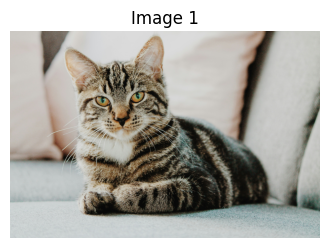


--- Processing Image 1 ---

>>> Running precision: P3109
Precision P3109 finished in 39.5864 seconds

>>> Running precision: FP32
Precision FP32 finished in 5.9934 seconds

>>> Running precision: FP64
Precision FP64 finished in 10.6629 seconds

>>> Running precision: TF32
Precision TF32 finished in 5.5312 seconds

>>> Running precision: BFloat16
Precision BFloat16 finished in 634.3544 seconds
✅ All images processed...


In [ ]:
# ============================================================
# SegFormer Multi-Precision + P3109 Quantization + Analysis
# ============================================================

import os
import time
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from io import BytesIO
# -----------------------------
# Core: P3109 simulation (vectorized, safe)
# -----------------------------
def float_to_p3109(x: torch.Tensor,
                   K: int = 8,
                   P: int = 3,
                   rounding: str = "nearest_even",
                   preserve_dtype: bool = True,
                   eps: float = 1e-45) -> torch.Tensor:
    if P < 1:
        raise ValueError("P must be >= 1")
    e_bits = K - P
    if e_bits < 1:
        raise ValueError("K and P invalid: need at least 1 exponent bit")
    f_bits = P - 1

    bias = (2 ** (e_bits - 1)) - 1
    max_stored_exp = (2 ** e_bits) - 2
    E_max_unbiased = max_stored_exp - bias
    E_min_unbiased = 1 - bias

    orig_shape = x.shape
    orig_dtype = x.dtype
    work_dtype = torch.float32 if orig_dtype != torch.float64 else torch.float64
    x_work = x.flatten().to(work_dtype)

    n = x_work.numel()
    out_flat = torch.zeros_like(x_work)

    is_nan = torch.isnan(x_work)
    is_inf = torch.isinf(x_work)
    signbit = torch.signbit(x_work)
    absx = x_work.abs()
    is_zero = (absx == 0)

    out_flat[is_nan] = float('nan')
    out_flat[is_inf] = torch.sign(x_work[is_inf]) * float('inf')

    finite_mask = torch.isfinite(x_work) & (~is_zero) & (~is_nan) & (~is_inf)
    if finite_mask.any():
        xf = absx[finite_mask]
        m, e = torch.frexp(xf)
        mant = m * 2.0
        exp_unbiased = e - 1

        normal_mask = (exp_unbiased >= E_min_unbiased) & (exp_unbiased <= E_max_unbiased)
        subnormal_mask = exp_unbiased < E_min_unbiased
        overflow_mask = exp_unbiased > E_max_unbiased

        idxs = torch.arange(xf.shape[0], device=xf.device)
        if normal_mask.any():
            nm_idx = idxs[normal_mask]
            mant_n = mant[normal_mask]
            exp_n = exp_unbiased[normal_mask].to(torch.long)

            f = mant_n - 1.0
            scaled = f * (2.0 ** f_bits)

            if rounding == "nearest_even":
                scaled_q = torch.round(scaled)
            elif rounding == "toward_zero":
                scaled_q = torch.trunc(scaled)
            elif rounding == "floor":
                scaled_q = torch.floor(scaled)
            elif rounding == "ceil":
                scaled_q = torch.ceil(scaled)
            else:
                raise ValueError("Unsupported rounding")

            carry_mask = (scaled_q >= (2 ** f_bits))
            if carry_mask.any():
                scaled_q = scaled_q.clone()
                exp_n = exp_n.clone()
                scaled_q[carry_mask] = 0.0
                exp_n[carry_mask] = exp_n[carry_mask] + 1

            overflow_after = exp_n > E_max_unbiased
            mant_q = 1.0 + scaled_q / (2.0 ** f_bits)
            val_n = mant_q * (2.0 ** exp_n)
            if overflow_after.any():
                val_n[overflow_after] = float('inf')

            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            normal_positions = finite_positions[nm_idx]
            out_flat[normal_positions] = val_n

        if subnormal_mask.any():
            sm_idx = idxs[subnormal_mask]
            scaled_fraction = xf[subnormal_mask] / (2.0 ** E_min_unbiased) * (2.0 ** f_bits)
            if rounding == "nearest_even":
                frac_q = torch.round(scaled_fraction)
            elif rounding == "toward_zero":
                frac_q = torch.trunc(scaled_fraction)
            elif rounding == "floor":
                frac_q = torch.floor(scaled_fraction)
            elif rounding == "ceil":
                frac_q = torch.ceil(scaled_fraction)
            else:
                raise ValueError("Unsupported rounding")

            frac_q = torch.clamp(frac_q, 0.0, float(2 ** f_bits - 1))
            val_s = (frac_q / (2.0 ** f_bits)) * (2.0 ** E_min_unbiased)

            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            sub_positions = finite_positions[sm_idx]
            out_flat[sub_positions] = val_s

        if overflow_mask.any():
            ov_idx = idxs[overflow_mask]
            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            ov_positions = finite_positions[ov_idx]
            out_flat[ov_positions] = float('inf')

    if signbit.any():
        out_flat[signbit] = -out_flat[signbit]

    if is_zero.any():
        zero_positions = torch.nonzero(is_zero, as_tuple=False).squeeze(1)
        out_flat[zero_positions] = x_work[zero_positions] * 0.0

    out = out_flat.view(orig_shape)
    return out.to(orig_dtype) if preserve_dtype else out

def float_to_p3109_safe(x, K=8, P=3, rounding="nearest_even", preserve_dtype=True):
    return float_to_p3109(x, K=K, P=P, rounding=rounding, preserve_dtype=preserve_dtype)

def quantize_model_p3109(model, K=8, P=3):
    for name, param in model.named_parameters():
        if param is None:
            continue
        with torch.no_grad():
            param.data.copy_(float_to_p3109_safe(param.data, K=K, P=P, preserve_dtype=True))
    return model

# -----------------------------
# Visualization utils
# -----------------------------
def visualize_comparison(original_image, pred_mask, title, save_path):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# -----------------------------
# Error metrics
# -----------------------------
def compute_error(a,b):
    a,b = a.float(), b.float()
    return {"MAE": float(torch.mean(torch.abs(a-b)).item()),
            "L2": float(torch.norm(a-b).item()),
            "MaxAbs": float(torch.max(torch.abs(a-b)).item())}

def dice_coeff(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    return (2.0 * intersection) / (pred_flat.numel() + target_flat.numel() + eps)

def iou_score(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    union = pred_flat.numel() + target_flat.numel() - intersection
    return intersection / (union + eps)

# -----------------------------
# Main experiment
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "nvidia/segformer-b2-finetuned-ade-512-512"

os.makedirs("pred_visualizations", exist_ok=True)
os.makedirs("features_cache", exist_ok=True)
os.makedirs("metrics_cache", exist_ok=True)

precisions = ["P3109","FP32","FP64","TF32","BFloat16"]

model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
processor = SegformerFeatureExtractor.from_pretrained(model_name)
model.eval()

img_urls = [

    # "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png",
    # "https://images.unsplash.com/photo-1560807707-8cc77767d783",
    # "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d",
    # "https://images.unsplash.com/photo-1518837695005-2083093ee35b",
    # "https://images.unsplash.com/photo-1536444894718-0021cbbeb45f",
    # "https://images.unsplash.com/photo-1654673131239-e45496600741",
    # "https://images.unsplash.com/photo-1654442617616-cc101a818f3b",
    # "https://images.unsplash.com/photo-1671347696331-bf4febb8d1d9",
    # "https://images.unsplash.com/photo-1615497001839-b0a0eac3274c",
    # "https://images.unsplash.com/photo-1516726817505-f5ed825624d8",
    # "https://images.unsplash.com/photo-1504208434309-cb69f4fe52b0",
    "https://images.unsplash.com/photo-1518791841217-8f162f1e1131"
]

for idx, url in enumerate(img_urls):
    print(f"\n--- Loading Image {idx+1} ---")
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        print(f"Image {idx+1} loaded successfully, size: {image.size}")

        # 显示图片
        plt.figure(figsize=(4,4))
        plt.imshow(image)
        plt.title(f"Image {idx+1}")
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"Failed to load Image {idx+1}: {e}")



feature_records = []

for idx, img_url in enumerate(img_urls):
    print(f"\n--- Processing Image {idx+1} ---")
    image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        dummy_out = model(**{k:v.float() for k,v in inputs.items()})
    output_shape = dummy_out.logits.shape[2:]
    gt_mask_resized = np.array(image.resize(output_shape[::-1]))[:,:,0]
    gt_mask_tensor = torch.from_numpy(gt_mask_resized).long()

    all_features = {}
    all_metrics = {}
    timings = {}

    for p in precisions:
        print(f"\n>>> Running precision: {p}")
        start = time.time()

        layer_outputs = {}

        if p == "P3109":
            p_model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
            p_model.eval()
            quantize_model_p3109(p_model, K=8, P=3)
            for name, module in p_model.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: float_to_p3109_safe(o)})
                    module.register_forward_hook(make_hook(name))
            p_inputs = {k: float_to_p3109_safe(v) if torch.is_tensor(v) else v for k, v in inputs.items()}
            with torch.no_grad():
                outputs = p_model(**p_inputs)

        elif p == "FP32":
            model_fp = model.float()
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: v.float() for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model_fp(**in_fp)

        elif p == "FP64":
            model_fp = model.double()
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: v.double() for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model_fp(**in_fp)

        elif p == "TF32":
            torch.backends.cuda.matmul.allow_tf32 = True
            model_fp = model.float()
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: v.float() for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model_fp(**in_fp)

        elif p == "BFloat16":
            model_fp = model.to(torch.bfloat16)
            model_fp.eval()
            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    def make_hook(n):
                        return lambda m, i, o: layer_outputs.update({n: o.detach().cpu()})
                    module.register_forward_hook(make_hook(name))
            in_fp = {k: v.to(torch.bfloat16) for k, v in inputs.items()}
            with torch.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', dtype=torch.bfloat16):
                with torch.no_grad():
                    outputs = model_fp(**in_fp)

        pred_mask = outputs.logits.argmax(dim=1)[0].detach().cpu()

        visualize_comparison(image, pred_mask.numpy(), f"{p} Prediction", f"pred_visualizations/img{idx+1}_{p}_compare.png")

        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask_tensor.flatten()
        min_len = min(len(pred_flat), len(gt_flat))
        acc = (pred_flat[:min_len] == gt_flat[:min_len]).float().mean().item()
        dice = dice_coeff(pred_mask, gt_mask_tensor)
        iou = iou_score(pred_mask, gt_mask_tensor)
        all_metrics[p] = {"pixel_acc": acc, "dice": dice, "iou": iou}

        timings[p] = time.time() - start
        print(f"Precision {p} finished in {timings[p]:.4f} seconds")

        all_features[p] = layer_outputs

        torch.save(layer_outputs, f'features_cache/img{idx+1}_{p}.pt')
        torch.save(all_metrics[p], f'metrics_cache/img{idx+1}_{p}.pt')

    baseline_feats = all_features.get("FP32", {})
    for p in precisions:
        if p == "FP32":
            continue
        for layer_name, feat in all_features[p].items():
            if layer_name not in baseline_feats:
                continue
            a = baseline_feats[layer_name]
            b = feat
            if isinstance(a, (list, tuple)) or isinstance(b, (list, tuple)):
                try:
                    for i_el in range(min(len(a), len(b))):
                        e = compute_error(a[i_el].float(), b[i_el].float())
                        feature_records.append({
                            "image_idx": idx+1,
                            "precision": p,
                            "layer": layer_name,
                            "elem_idx": i_el,
                            **e
                        })
                except Exception:
                    continue
            else:
                try:
                    e = compute_error(a.float(), b.float())
                    feature_records.append({
                        "image_idx": idx+1,
                        "precision": p,
                        "layer": layer_name,
                        "elem_idx": 0,
                        **e
                    })
                except Exception:
                    continue

    metrics_df = pd.DataFrame.from_dict(all_metrics, orient="index")
    metrics_df.to_csv(f"mask_metrics_img{idx+1}.csv")

if len(feature_records) > 0:
    feat_df = pd.DataFrame(feature_records)
    feat_df.to_csv("feature_diff_summary.csv", index=False)

print("✅ All images processed...")


In [ ]:
df = pd.read_csv("mask_metrics_img1.csv")
print(df.columns)
print(df.head())


Index(['Unnamed: 0', 'pixel_acc', 'dice', 'iou'], dtype='object')
  Unnamed: 0  pixel_acc      dice       iou
0      P3109   0.002380  0.002380  0.001192
1       FP32   0.001892  0.001892  0.000947
2       FP64   0.001892  0.001892  0.000947
3       TF32   0.001892  0.001892  0.000947
4   BFloat16   0.001831  0.001831  0.000916


In [ ]:
print("\n==== Debug: all_metrics content ====")
print(all_metrics)
print("Columns:", list(metrics_df.columns))

print("\n==== Debug: first few feature records ====")
for r in feature_records[:3]:
    print(r)



==== Debug: all_metrics content ====
{'P3109': {'pixel_acc': 0.00238037109375, 'dice': 0.0023803710936773567, 'iou': 0.001191603776430945}, 'FP32': {'pixel_acc': 0.00189208984375, 'dice': 0.001892089843692258, 'iou': 0.0009469407703532108}, 'FP64': {'pixel_acc': 0.00189208984375, 'dice': 0.001892089843692258, 'iou': 0.0009469407703532108}, 'TF32': {'pixel_acc': 0.00189208984375, 'dice': 0.001892089843692258, 'iou': 0.0009469407703532108}, 'BFloat16': {'pixel_acc': 0.0018310546875, 'dice': 0.0018310546874441207, 'iou': 0.0009163663021285244}}
Columns: ['pixel_acc', 'dice', 'iou']

==== Debug: first few feature records ====
{'image_idx': 1, 'precision': 'P3109', 'layer': 'segformer.encoder.patch_embeddings.0.proj', 'elem_idx': 0, 'MAE': 0.05089158937335014, 'L2': 76.50264739990234, 'MaxAbs': 0.9217230677604675}
{'image_idx': 1, 'precision': 'P3109', 'layer': 'segformer.encoder.patch_embeddings.0.layer_norm', 'elem_idx': 0, 'MAE': 0.04394965246319771, 'L2': 64.65306091308594, 'MaxAbs': 0


 Loaded feature_diff_summary.csv, columns: ['image_idx', 'precision', 'layer', 'elem_idx', 'MAE', 'L2', 'MaxAbs']

 Top 10 layers with highest MAE:
                                                    MAE
layer                                                  
decode_head.linear_fuse                        4.663172
segformer.encoder.block.0.0.attention.self.sr  1.479401
segformer.encoder.block.0.2.attention.self.sr  1.273376
segformer.encoder.block.0.1.attention.self.sr  1.106292
segformer.encoder.block.1.3.attention.self.sr  0.847180
segformer.encoder.block.1.2.attention.self.sr  0.712075
decode_head.classifier                         0.617423
segformer.encoder.block.1.1.attention.self.sr  0.599650
decode_head.linear_c.3.proj                    0.531144
segformer.encoder.block.1.0.attention.self.sr  0.529860


<Figure size 1000x400 with 0 Axes>

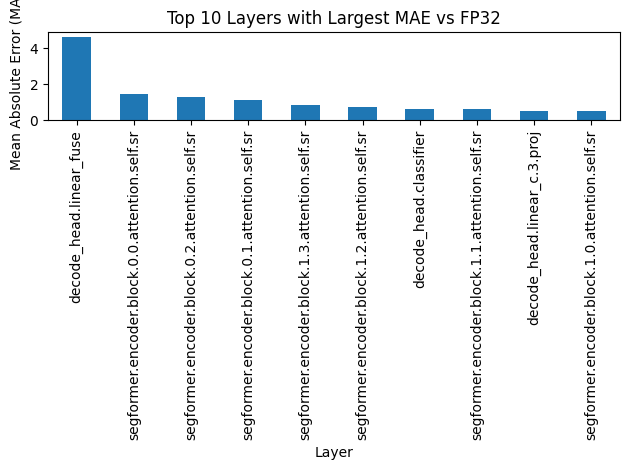


 Mean MAE per Precision:
                MAE
precision          
P3109      0.707297
BFloat16   0.022094
FP64       0.000002
TF32       0.000000


<Figure size 600x400 with 0 Axes>

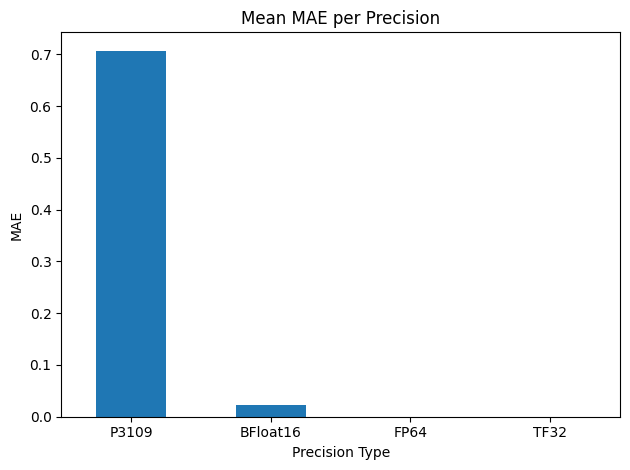


 Top 10 layers with largest L2 difference:
                                                    L2
layer                                                 
decode_head.linear_fuse                   22337.801434
decode_head.classifier                     1276.188612
segformer.encoder.block.0.2.mlp.dense1      984.702255
segformer.encoder.block.1.3.mlp.dense1      951.449234
segformer.encoder.block.1.2.mlp.dense1      863.656617
segformer.encoder.block.0.2.layer_norm_2    734.222803
segformer.encoder.block.0.1.mlp.dense1      725.631319
segformer.encoder.block.2.3.mlp.dense1      646.467714
segformer.encoder.block.1.1.mlp.dense1      626.283596
segformer.encoder.block.0.1.layer_norm_2    615.414284


<Figure size 1000x400 with 0 Axes>

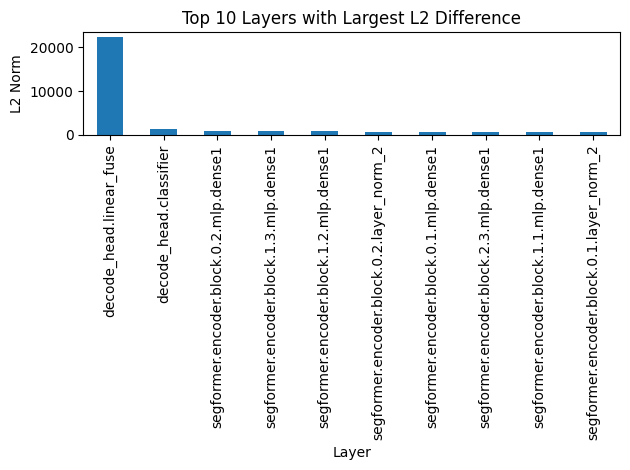


 Top 10 layers with largest MaxAbs difference:
                                                  MaxAbs
layer                                                   
decode_head.linear_fuse                        52.544553
segformer.encoder.patch_embeddings.3.proj      21.057041
segformer.encoder.patch_embeddings.2.proj      16.493334
segformer.encoder.block.0.1.attention.self.sr  11.025169
segformer.encoder.block.0.2.attention.self.sr  10.965477
segformer.encoder.block.0.0.attention.self.sr  10.774634
segformer.encoder.block.1.3.mlp.dense2          9.764601
segformer.encoder.block.1.3.attention.self.sr   9.201941
segformer.encoder.block.0.2.mlp.dense1          8.923912
segformer.encoder.block.1.0.attention.self.sr   7.259691


<Figure size 1000x400 with 0 Axes>

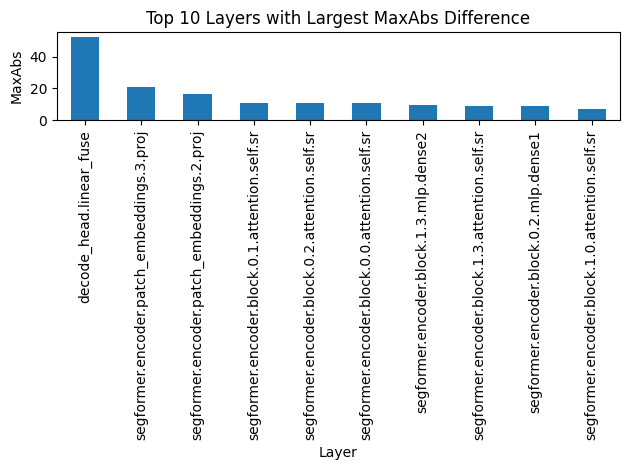

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ================================
# 读取 feature_diff_summary.csv
# ================================
df = pd.read_csv("feature_diff_summary.csv")

print("\n Loaded feature_diff_summary.csv, columns:", df.columns.tolist())

# ========================================================
# 1. 各 Layer MAE 平均值（Top-10）
# ========================================================
top10_layers = (
    df.groupby("layer")[["MAE"]]
    .mean()
    .sort_values("MAE", ascending=False)
    .head(10)
)

print("\n Top 10 layers with highest MAE:")
print(top10_layers)

# 画图
plt.figure(figsize=(10, 4))
top10_layers.plot(kind='bar', legend=False)
plt.title("Top 10 Layers with Largest MAE vs FP32")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Layer")
plt.xticks(rotation=90)
plt.tight_layout()

os.makedirs("plots", exist_ok=True)
plt.savefig("plots/top10_layers_mae.png")
plt.show()


# ========================================================
# 2. 各 Precision 的平均 MAE（例如 P3109、FP32、FP64...）
# ========================================================
precision_mae = (
    df.groupby("precision")[["MAE"]]
    .mean()
    .sort_values("MAE", ascending=False)
)

print("\n Mean MAE per Precision:")
print(precision_mae)

plt.figure(figsize=(6,4))
precision_mae.plot(kind='bar', legend=False)
plt.title("Mean MAE per Precision")
plt.ylabel("MAE")
plt.xlabel("Precision Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("plots/precision_mae.png")
plt.show()


# ========================================================
# 3. 每个 Layer 的 L2 范数（Top-10）
# ========================================================
top10_l2 = (
    df.groupby("layer")[["L2"]]
    .mean()
    .sort_values("L2", ascending=False)
    .head(10)
)

print("\n Top 10 layers with largest L2 difference:")
print(top10_l2)

plt.figure(figsize=(10,4))
top10_l2.plot(kind='bar', legend=False)
plt.title("Top 10 Layers with Largest L2 Difference")
plt.ylabel("L2 Norm")
plt.xlabel("Layer")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("plots/top10_layers_l2.png")
plt.show()


# ========================================================
# 4. 每个 Layer 的 MaxAbs（Top-10）
# ========================================================
top10_maxabs = (
    df.groupby("layer")[["MaxAbs"]]
    .mean()
    .sort_values("MaxAbs", ascending=False)
    .head(10)
)

print("\n Top 10 layers with largest MaxAbs difference:")
print(top10_maxabs)

plt.figure(figsize=(10,4))
top10_maxabs.plot(kind='bar', legend=False)
plt.title("Top 10 Layers with Largest MaxAbs Difference")
plt.ylabel("MaxAbs")
plt.xlabel("Layer")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("plots/top10_layers_maxabs.png")
plt.show()


Displaying img1_BFloat16_compare.png


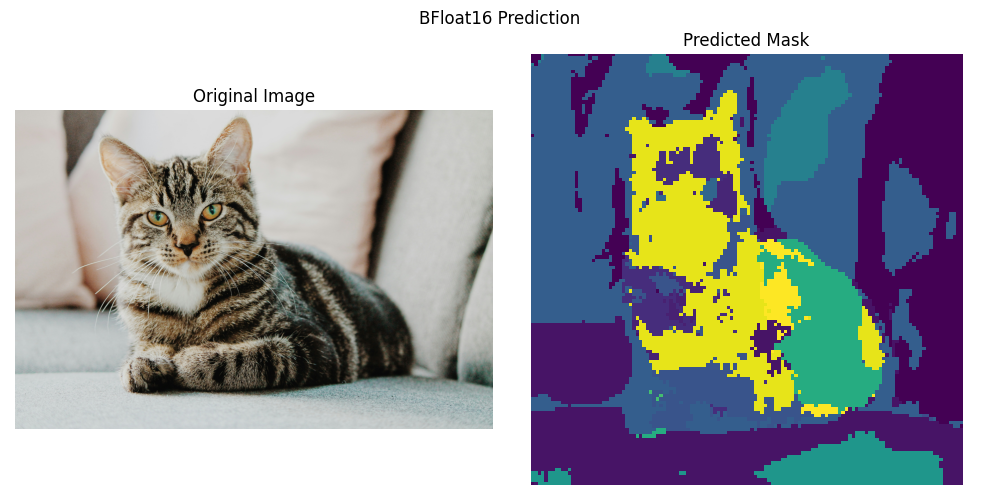

Displaying img1_FP32_compare.png


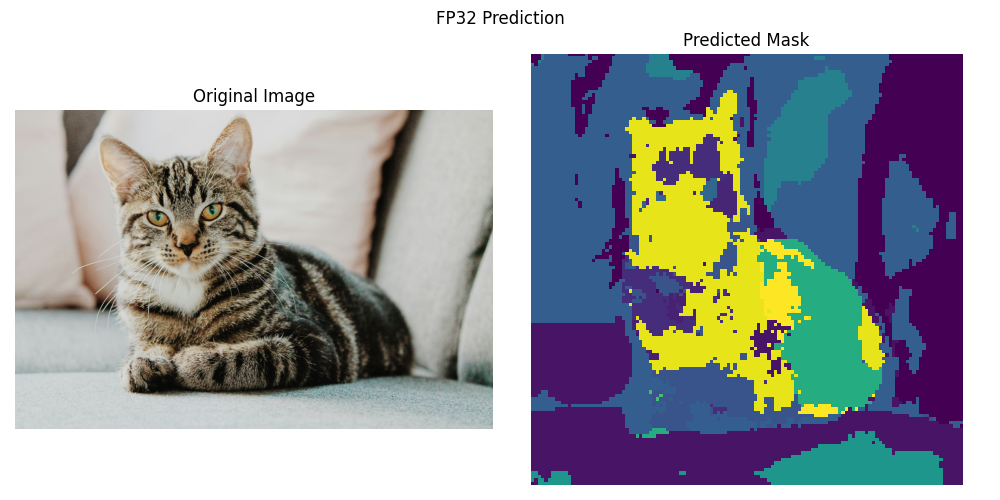

Displaying img1_FP64_compare.png


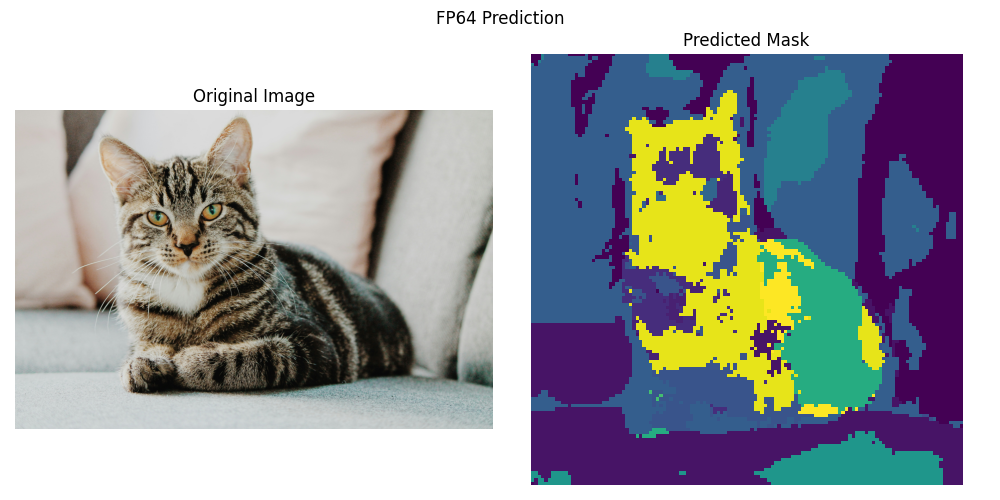

Displaying img1_P3109_compare.png


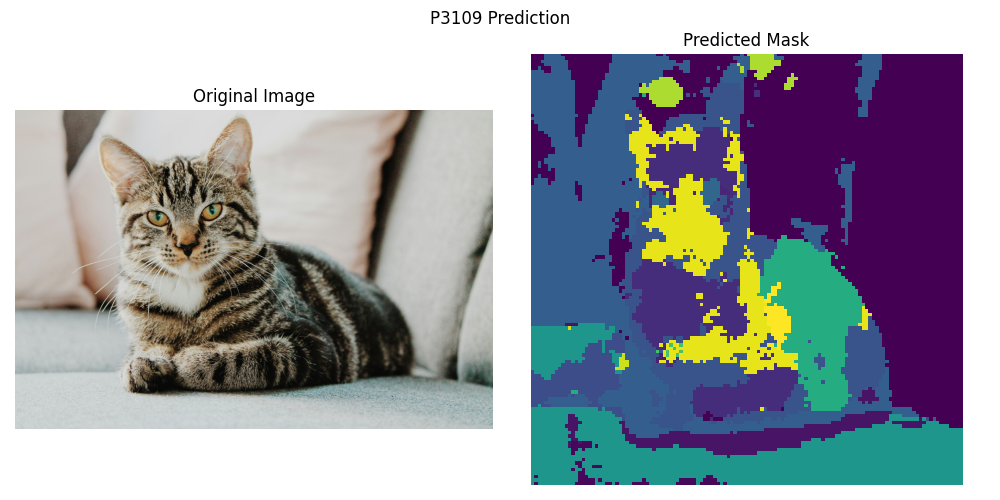

Displaying img1_TF32_compare.png


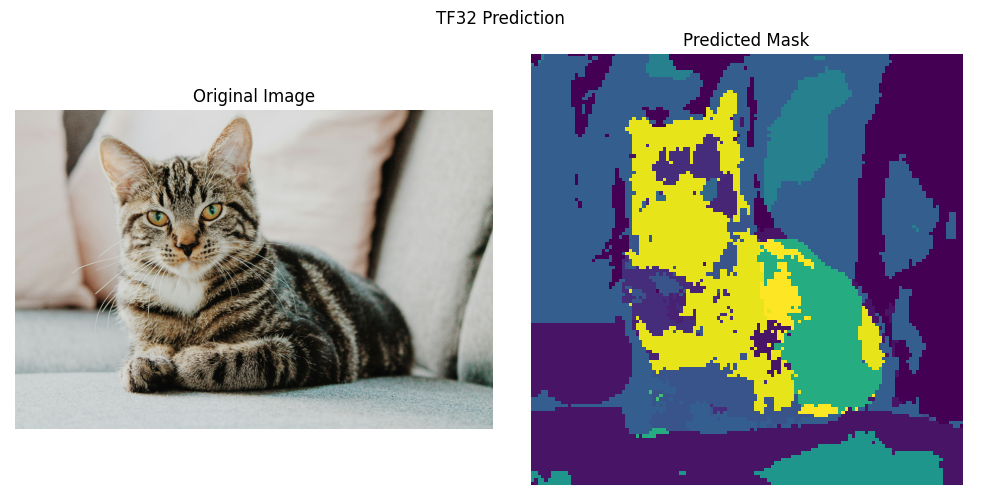

In [ ]:
import os
from IPython.display import display
from PIL import Image

vis_dir = "pred_visualizations"
all_files = sorted([f for f in os.listdir(vis_dir) if f.endswith(".png")])

for f in all_files:
    img_path = os.path.join(vis_dir, f)
    print(f"Displaying {f}")
    img = Image.open(img_path)
    display(img)


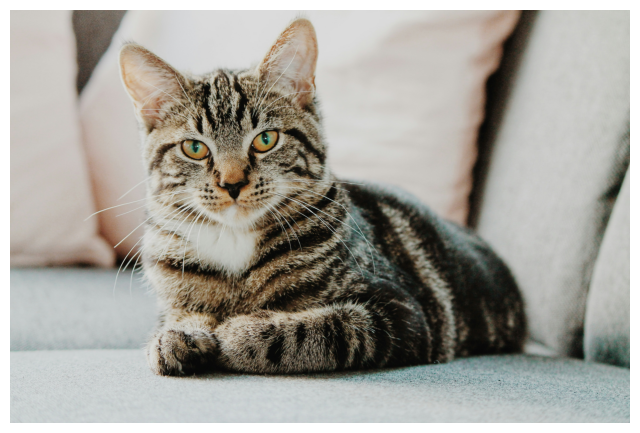

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 你的图片 URL
url = "https://images.unsplash.com/photo-1518791841217-8f162f1e1131"

# 下载图像
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# 显示图像
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()


/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:35: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  super().__init__(*args, **kwargs)


Configuring layer segformer.encoder.block.0.0.attention.self.sr to FP64
Configuring layer segformer.encoder.block.0.1.attention.self.sr to FP64
Configuring layer segformer.encoder.block.0.2.attention.self.sr to FP64
Configuring layer segformer.encoder.block.1.0.attention.self.sr to FP64
Configuring layer segformer.encoder.block.1.1.attention.self.sr to FP64
Configuring layer segformer.encoder.block.1.2.attention.self.sr to FP64
Configuring layer segformer.encoder.block.1.3.attention.self.sr to FP64
Configuring layer decode_head.linear_c.3.proj to FP64
Configuring layer decode_head.linear_fuse to FP64
Configuring layer decode_head.classifier to FP64

--- Processing Image 1 ---
Image 1 inference done in 7.4625s


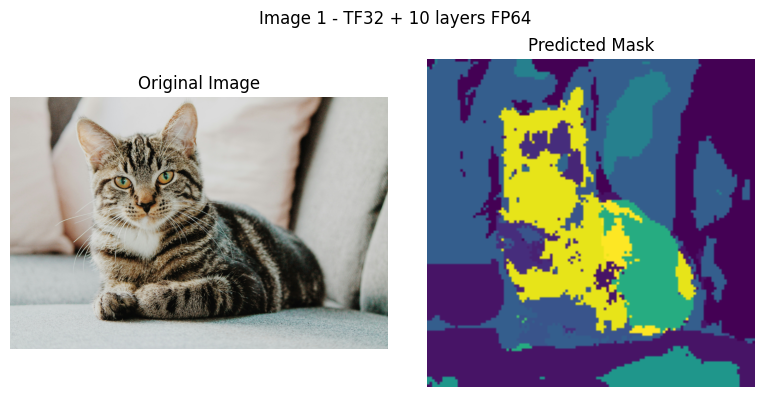

In [ ]:
# ============================================================
# SegFormer Sensitive Layer FP64 + TF32 Mix Precision Inference
# ============================================================

import os
import time
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "nvidia/segformer-b2-finetuned-ade-512-512"

# -----------------------------
# 敏感层名单
# -----------------------------
sensitive_layers = [
    "decode_head.linear_fuse",
    "segformer.encoder.block.0.0.attention.self.sr",
    "segformer.encoder.block.0.2.attention.self.sr",
    "segformer.encoder.block.0.1.attention.self.sr",
    "segformer.encoder.block.1.3.attention.self.sr",
    "segformer.encoder.block.1.2.attention.self.sr",
    "decode_head.classifier",
    "segformer.encoder.block.1.1.attention.self.sr",
    "decode_head.linear_c.3.proj",
    "segformer.encoder.block.1.0.attention.self.sr"
]

# -----------------------------
# 工具函数: 可视化 mask
# -----------------------------
def visualize_comparison(original_image, pred_mask, title, save_path):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

# -----------------------------
# 加载模型 + processor
# -----------------------------
model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
processor = SegformerFeatureExtractor.from_pretrained(model_name)
model.eval()

# -----------------------------
# 构建混合精度模型: TF32 + 10层 FP64
# -----------------------------
# Initialize the model in float (for TF32 baseline)
model_mix = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device).float()
model_mix.eval()

# Set TF32 globally for matmul if available
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True

for name, module in model_mix.named_modules():
    if name in sensitive_layers:
        print(f"Configuring layer {name} to FP64")
        # Convert parameters of sensitive layer to double
        for param_name, param in module.named_parameters(recurse=False):
            if param is not None:
                param.data = param.data.double()

        # Register a pre-forward hook to cast inputs to double
        def make_pre_hook(mod_name):
            def pre_hook_fn(mod, input_tuple):
                # Cast all tensor inputs to double
                new_input_tuple = tuple(i.double() if torch.is_tensor(i) else i for i in input_tuple)
                return new_input_tuple
            return pre_hook_fn

        # Register a forward hook to cast outputs back to float for downstream layers
        def make_post_hook(mod_name):
            def post_hook_fn(mod, input_tuple, output):
                # Cast output back to float if it's a tensor
                if torch.is_tensor(output):
                    return output.float()
                elif isinstance(output, (list, tuple)):
                    return tuple(o.float() if torch.is_tensor(o) else o for o in output)
                return output
            return post_hook_fn

        module.register_forward_pre_hook(make_pre_hook(name))
        module.register_forward_hook(make_post_hook(name))

# -----------------------------
# 测试图片
# -----------------------------
img_urls = [
    "https://images.unsplash.com/photo-1518791841217-8f162f1e1131"
]

for idx, url in enumerate(img_urls):
    print(f"\n--- Processing Image {idx+1} ---")
    try:
        response = requests.get(url, stream=True)
        image = Image.open(BytesIO(response.raw.read())).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        # All inputs should be float (for TF32 baseline)
        inputs_mix = {k: v.float() for k, v in inputs.items()}

        # Inference
        start = time.time()
        with torch.no_grad():
            outputs_mix = model_mix(**inputs_mix)
        elapsed = time.time() - start

        pred_mask_mix = outputs_mix.logits.argmax(dim=1)[0].cpu()
        print(f"Image {idx+1} inference done in {elapsed:.4f}s")

        visualize_comparison(image, pred_mask_mix.numpy(),
                             title=f"Image {idx+1} - TF32 + 10 layers FP64",
                             save_path=f"pred_visualizations/img{idx+1}_mix.png")

    except Exception as e:
        print(f"Failed to process Image {idx+1}: {e}")


--- Processing Image 1 (Pure TF32) ---
Image 1 pure TF32 inference done in 5.8654s


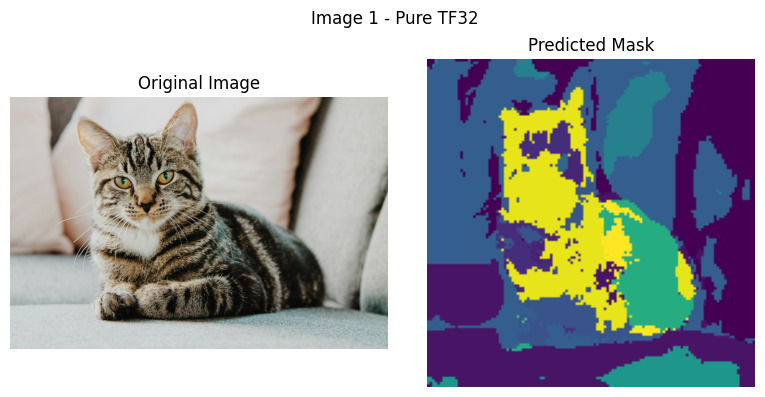

In [ ]:
# -----------------------------
# Pure TF32 Inference
# -----------------------------
print(f"\n--- Processing Image {idx+1} (Pure TF32) ---")
try:
    # Ensure TF32 is enabled
    if device == "cuda":
        torch.backends.cuda.matmul.allow_tf32 = True

    model_tf32 = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device).float()
    model_tf32.eval()

    # Inputs are already loaded and preprocessed
    inputs_tf32 = {k: v.float() for k, v in inputs.items()}

    start = time.time()
    with torch.no_grad():
        outputs_tf32 = model_tf32(**inputs_tf32)
    elapsed_tf32 = time.time() - start

    pred_mask_tf32 = outputs_tf32.logits.argmax(dim=1)[0].cpu()
    print(f"Image {idx+1} pure TF32 inference done in {elapsed_tf32:.4f}s")

    visualize_comparison(image, pred_mask_tf32.numpy(),
                         title=f"Image {idx+1} - Pure TF32",
                         save_path=f"pred_visualizations/img{idx+1}_pure_tf32.png")

except Exception as e:
    print(f"Failed to process Image {idx+1} for pure TF32: {e}")


In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc
# !jupyter nbconvert --log-level INFO --to pdf /path/to/notebook_file.ipynb # make sure the ipynb name is correct
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MSCS/260
%pwd
# !ls
!jupyter nbconvert --to pdf "AllIn1_3.ipynb"


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag